# Strikout Prediction (2024) - Exploratory Data Analysis
## Introduction
Using the latest data from MLB, can you predict when a strikeout occurs? The newest feature available, arm_angle, allows us to see how a pitch moves relative to the pitcher's unique release characteristics. While previous release characteristic data was helpful (e.g. release point XYZ), arm angle allows us to know more about whether a pitcher is throwing more overhead, more to the side, or more submarine, and anywhere in between. The combination of arm angle and pitch movement can elevate our understanding of how a pitcher generates strikes -- and ultimately strikeouts.
## Ideas
* Maybe I can build a bayesian model to predict strikes. P(strike|pitch_name,speed,rotation, etc). I may be able to do it in stages with updating. 

## Variable Meaning
Some of these seem not up to date. For example
* pitch_type - The type of pitch derived from Statcast.
* pitch_name - The name of the pitch derived from the Statcast Data.
* on_3b - Pre-pitch MLB Player Id of Runner on 3B.
* on_2b - Pre-pitch MLB Player Id of Runner on 2B.
* on_1b - Pre-pitch MLB Player Id of Runner on 1B.
* inning - Pre-pitch inning number.
* inning_topbot - Pre-pitch top or bottom of inning.
* outs_when_up - Pre-pitch number of outs.
* balls - Pre-pitch number of balls in count.
* strikes - Pre-pitch number of strikes in count.
* n_thruorder_pitcher
* stand - Side of the plate batter is standing.
* p_throws - Hand pitcher throws with.
* sz_top - Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
* sz_bot - Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
* pfx_x - Horizontal movement in feet from the catcher's perspective.
* pfx_z - Vertical movement in feet from the catcher's perpsective.
* arm_angle
* release_speed - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
* release_pos_x - Horizontal Release Position of the ball measured in feet from the catcher's perspective.
* release_extension - Release extension of pitch in feet as tracked by Statcast.
* release_pos_z - Vertical Release Position of the ball measured in feet from the catcher's perspective.
* release_spin_rate
* spin_axis - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball
* bat_speed
* swing_length
* is_strike
* k        
## Open Questions
* Why are the two variables associated with the bat swing the only variables with null values?
* Does pitch speed affect likelihood of strikes?
* Does pitch speed conditionally affect likelihood of strikes?
* How does the pitch type order affect the likelihood of strikes?
* Basebakk savant claims the `on_xb` variables are player ID, but the data seems to suggest a binary.
## Import

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Read Data

In [3]:
training_data_df = pd.read_csv('Data/train.csv')

## Data Summary Statistics

In [4]:
print('\033[1mShape: \033[0m')
print(training_data_df.shape)

print('\n' + '\033[1mData Types: \033[0m')
print(training_data_df.dtypes)

print('\n' + '\033[1mNumber of Null Values per Column: \033[0m')
print(training_data_df.isnull().sum())
print('\033[1mTotal Number of Null Values:\033[0m')
print(training_data_df.isnull().sum().sum())

print('\n' + '\033[1mNumber of Unique Values per Column: \033[0m')
print(training_data_df.nunique())
print('\033[1mNumber of Columns with a Different Amount of Unique Values:\033[0m')
print(training_data_df.nunique().nunique())

print('\n' + '\033[1mResponse Variable Count: \033[0m')
print(training_data_df.is_strike.value_counts())
print('\n' + '\033[1mGeneral Info:\033[0m')
print(training_data_df.info())

Shape: 
(666512, 29)

Data Types: 
index                    int64
pitch_type              object
pitch_name              object
on_3b                     bool
on_2b                     bool
on_1b                     bool
inning                   int64
inning_topbot           object
outs_when_up             int64
balls                    int64
strikes                  int64
n_thruorder_pitcher      int64
stand                   object
p_throws                object
sz_top                 float64
sz_bot                 float64
pfx_x                  float64
pfx_z                  float64
arm_angle              float64
release_speed          float64
release_pos_x          float64
release_extension      float64
release_pos_z          float64
release_spin_rate      float64
spin_axis              float64
bat_speed              float64
swing_length           float64
is_strike                int64
k                        int64
dtype: object

Number of Null Values per Column: 
index           

### Summary Stats Interpretation
This data set has 29 unique variables and 666,512 entries.  Having such a large number of entries should help the results to be fairly decisive.  Of the 29 variables, 1 is the response variable (`is_strike`) and 1 is an index variable which identifies each pitch.  The other 27 variables are the predictive variables.  The inputs contain a fair mix of categorical and numeric data.  Most of the variables do not contain NULL values, but two variables do: `bat_speed` and `swing_length`.  Perhaps these are pitches where the batter didn't swing?  The number of unique values tells us a few things:
1. There appear to be 17 unique pitches
2. The largest amount of innings is 14
3. Many of the numerical pitch data have the same values.  This could be because the instruments were not precise enough to tell the difference between each pitch
4. Extending the following reasoning, the release_spin_rate may be the most precise measurement, or maybe it just has the most variation.

The response variable count shows that this data is unbalanced; there are less strikes than non-strikes.
## Figures

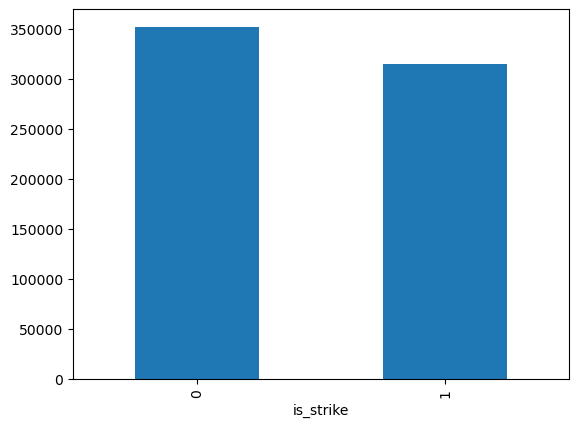

In [5]:
fig, ax = plt.subplots()
training_data_df.is_strike.value_counts().plot(kind='bar',ax=ax)
plt.show()

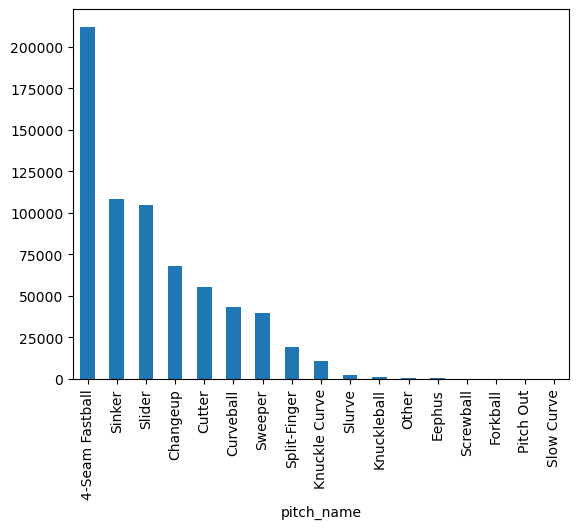

In [6]:
fig, ax = plt.subplots()
training_data_df.pitch_name.value_counts().plot(kind='bar',ax=ax)
plt.show()

Each pitch should have different mechanical qualities to it, so it may be enlightening to get an idea of each pitch by looking at the conditional distributions

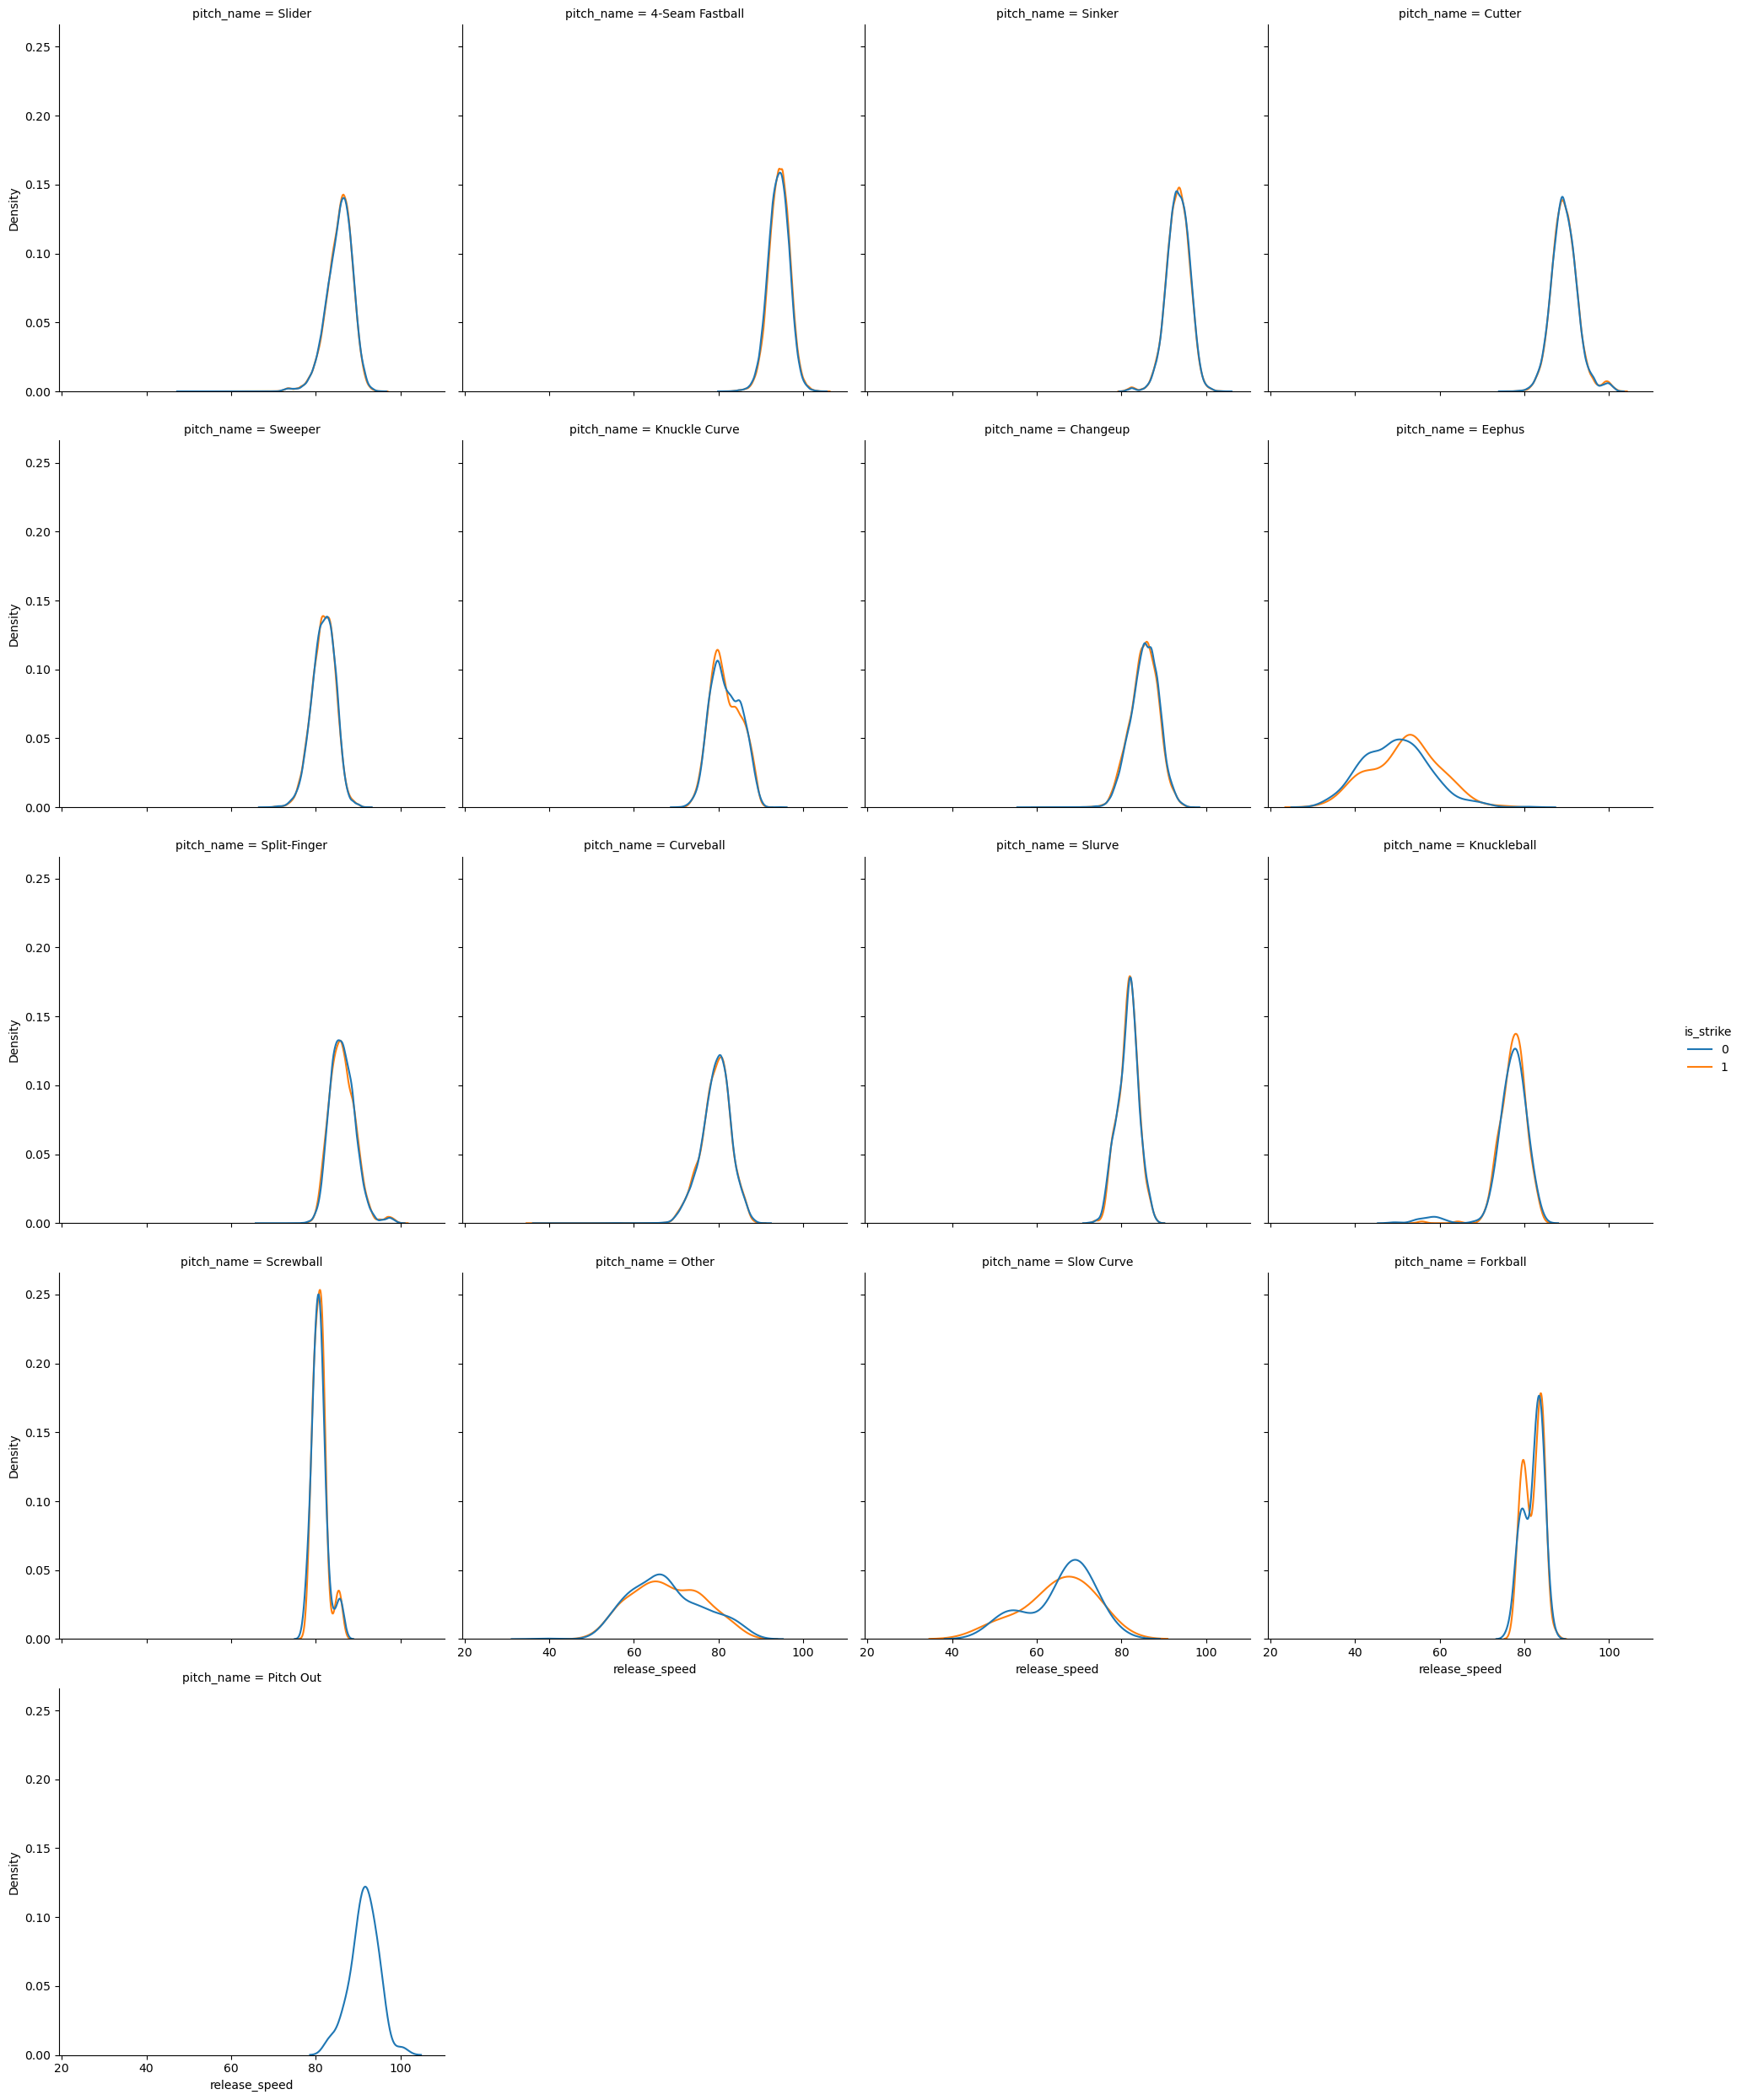

In [7]:
sns.displot(training_data_df, x="release_speed", col="pitch_name", kind = "kde", hue = "is_strike", col_wrap = 4, common_norm = False)

Visually, it seems like the pitch speed does not significantly affect how likely a pitch is to be a strike, but I would have to check empirically to prove that. Maybe the pitch speed conditionally affects the strike likelihood?

It could be useful to look at the frequency of each pitch by inning

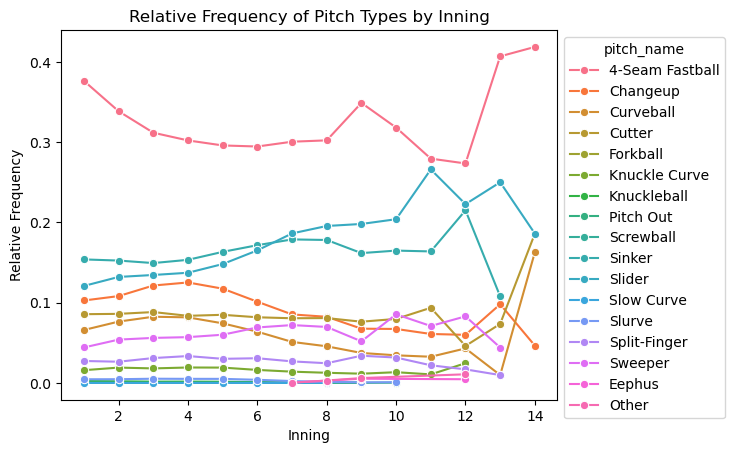

In [8]:
counts = training_data_df.groupby(['inning', 'pitch_name']).size().reset_index(name='count')
total_pitches = training_data_df.groupby('inning').size().reset_index(name='total')
counts = counts.merge(total_pitches, on='inning')
counts['relative_frequency'] = counts['count'] / counts['total']

ax = sns.lineplot(data=counts, x='inning', y='relative_frequency', hue='pitch_name', marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Inning")
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency of Pitch Types by Inning")
plt.show()


It seems like fastballs are by far the most popular pitch and are used most often in the 1st, 2nd, and 9th innings. This could reflect a strategy where pitchers are trying to conserve their energy when pitching in the middle innings, but the closer comes in and pitches their brains out. The four most popular pitches are the:
* 4-Seam Fastball
* Sinker
* Slider
* Changeup

Perhaps these pitches are used the most because they are the most effective, or maybe some of the other pitches are only effective when they are used infrequently.

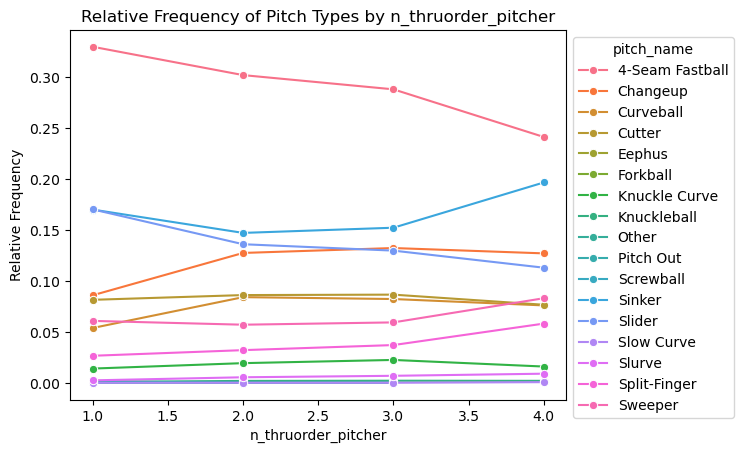

In [9]:
counts = training_data_df.groupby(['n_thruorder_pitcher', 'pitch_name']).size().reset_index(name='count')
total_pitches = training_data_df.groupby('n_thruorder_pitcher').size().reset_index(name='total')
counts = counts.merge(total_pitches, on='n_thruorder_pitcher')
counts['relative_frequency'] = counts['count'] / counts['total']

ax = sns.lineplot(data=counts, x='n_thruorder_pitcher', y='relative_frequency', hue='pitch_name', marker='o')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("n_thruorder_pitcher")
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency of Pitch Types by n_thruorder_pitcher")
plt.show()

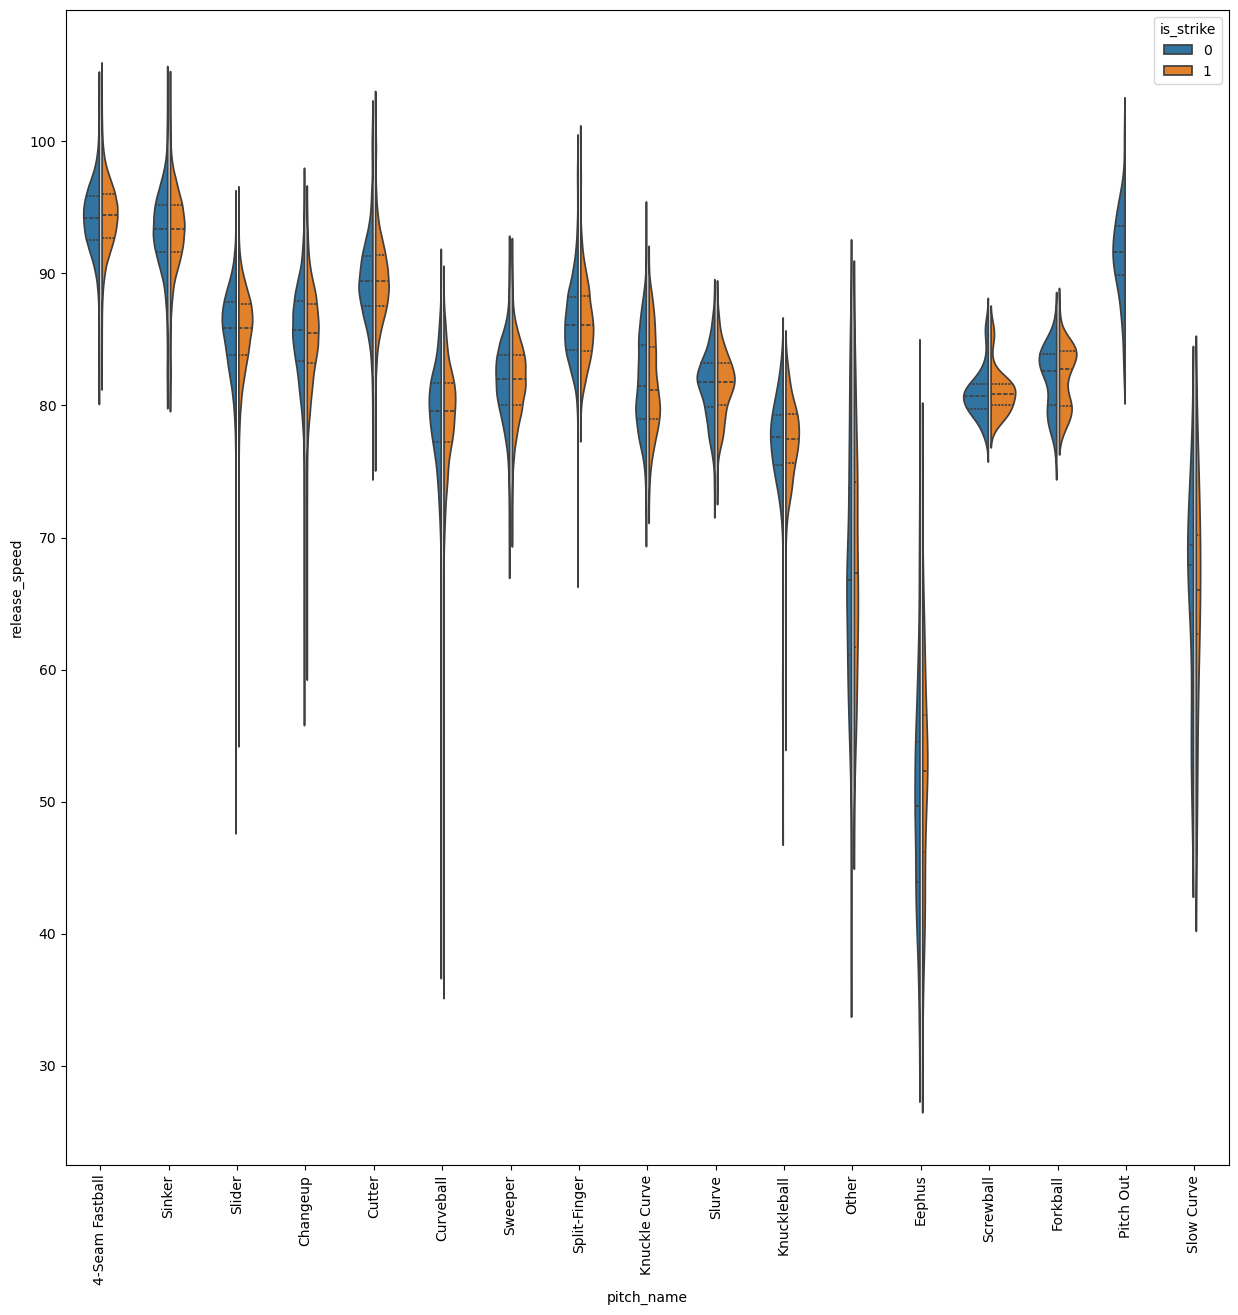

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(data=training_data_df, x="pitch_name", y="release_speed", hue="is_strike", split=True, gap=.1, inner="quart", order = training_data_df.pitch_name.value_counts().index)
ax.tick_params(axis='x', rotation=90)
plt.show()

This seems to show that speed DOES matter for multiple pitches. As expected, the 4-seam Fastball does seem to be more likely to be a strike the faster it is. On the other hand, changeups need to be a bit slower to 

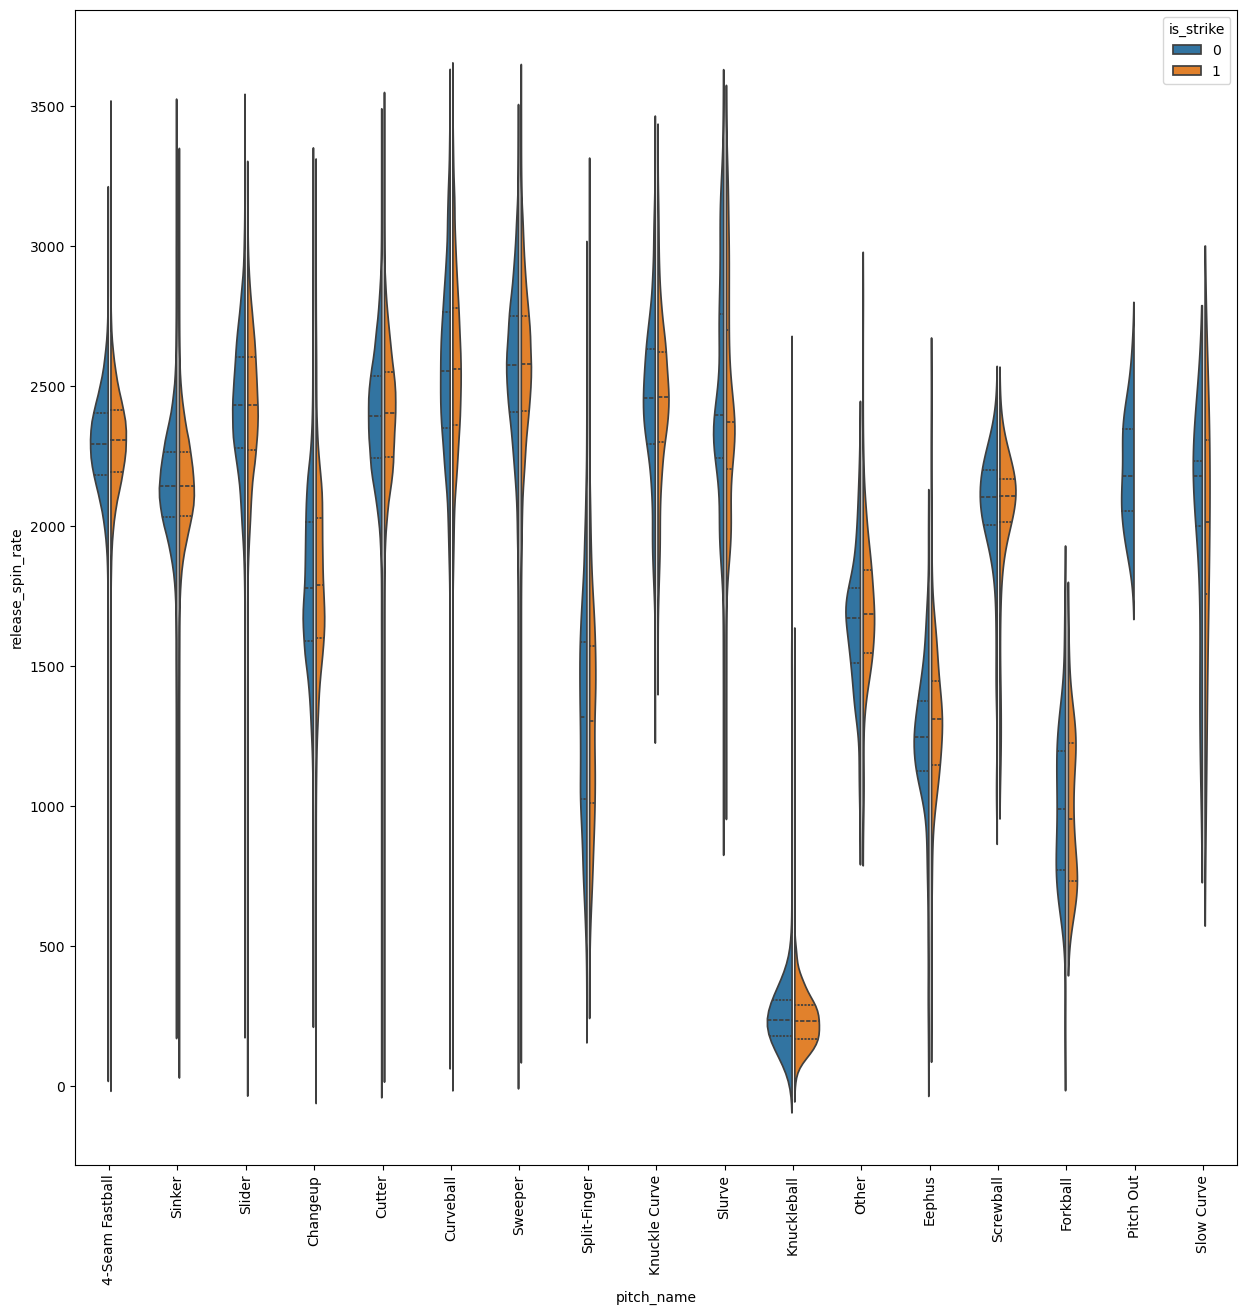

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(data=training_data_df, x="pitch_name", y="release_spin_rate", hue="is_strike", split=True, gap=.1, inner="quart", order = training_data_df.pitch_name.value_counts().index)
ax.tick_params(axis='x', rotation=90)
plt.show()

This seems to show that often times higher spin is more likely to be a strike. On average, the sweeper and curveball have the most spin.

In [12]:
training_data_df.pfx_tot = (training_data_df.pfx_x.copy()**2 + training_data_df.pfx_z.copy()**2)**0.5

C:\Users\Clarke\AppData\Local\Temp\ipykernel_43532\3308533970.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  training_data_df.pfx_tot = (training_data_df.pfx_x.copy()**2 + training_data_df.pfx_z.copy()**2)**0.5


In [13]:
print(training_data_df.pfx_tot)

0         0.429535
1         1.654630
2         0.623699
3         0.686586
4         0.997246
            ...   
666507    1.336638
666508    1.353255
666509    0.745453
666510    0.932952
666511    1.612979
Length: 666512, dtype: float64


In [14]:
print(training_data_df.pfx_x)

0         0.18
1         0.63
2         0.61
3         0.15
4         0.99
          ... 
666507   -1.29
666508   -0.68
666509    0.09
666510    0.48
666511    0.41
Name: pfx_x, Length: 666512, dtype: float64


ValueError: Could not interpret value `pfx_tot` for `y`. An entry with this name does not appear in `data`.

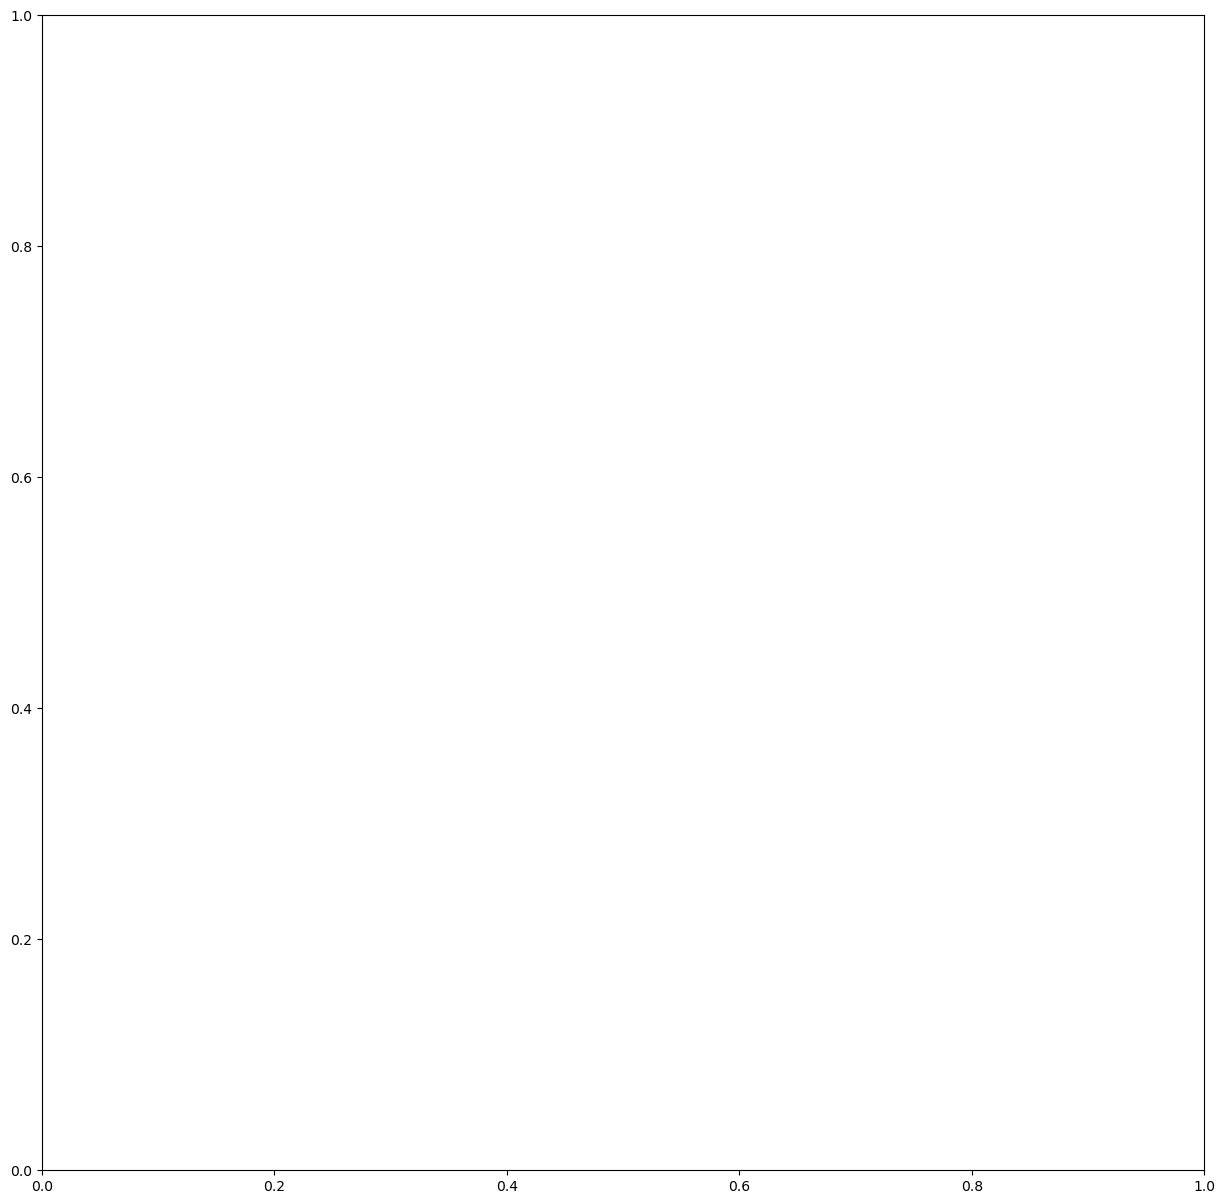

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(data=training_data_df, x="pitch_name", y="pfx_tot", hue="is_strike", split=True, gap=.1, inner="quart")
ax.tick_params(axis='x', rotation=90)
plt.show()

In [ ]:
training_data_df.columns

In [ ]:
training_data_df.pfx_tot

In [18]:
training_data_df.pitch_name.value_counts().index

Index(['4-Seam Fastball', 'Sinker', 'Slider', 'Changeup', 'Cutter',
       'Curveball', 'Sweeper', 'Split-Finger', 'Knuckle Curve', 'Slurve',
       'Knuckleball', 'Other', 'Eephus', 'Screwball', 'Forkball', 'Pitch Out',
       'Slow Curve'],
      dtype='object', name='pitch_name')